# Задание 
Этап 1. При найме персонала в массовых профессиях, рекрутерам приходится просматривать и вручную оценивать тысячи резюме. Помимо того, что эта задача трудная, она занимает много времени и найденный через несколько недель наиболее подходящий кандидат может уже не рассматривать предложения о трудоустройстве.  
Автоматизация этого процесса существенно экономит деньги, силы и время. 


Данные будут представлены в виде датасета с основными параметрами вакансий\резюме (название, описание, требования по опыту работы, графику работы, знанию иностранных языков, перечень навыков и т. д.) 
Вакансии и резюме представлены парами. 

Целевая переменная – откликнется (1) или не откликнется (0) соискатель с данным резюме на данную вакансию.


## Импорт библиотек

In [209]:
import pandas as pd
import numpy as np
from datetime import datetime

# Для визуализации
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Работа с текстом
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
from pymystem3 import Mystem
from nltk.stem.wordnet import WordNetLemmatizer
import re
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Для обработки признаков

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer
from category_encoders import HashingEncoder


# Для моделей
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

seed = 17


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lshinal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Данные

In [210]:
df = pd.read_csv('vacancy_resume_data.csv')

In [211]:
df.head()

,resume_id,vacancy_id,birth_date,resume_position,resume_salary_from,resume_city_id,resume_city_search_job,resume_is_leaving,resume_offer_education_id,resume_is_foreign_language,...,vacancy_description,vacancy_offer_education_id,vacancy_offer_experience_year_count,vacany_company_id,vacancy_is_agency,vacancy_city_id,vacancy_operating_schedule_comment,vacancy_offer_experience_year_id,target_task_1,target_task_2
0,28826595,43881267,1996-01-01,Корректор,20000.0,1.0,False,False,4.0,False,...,<strong>Требования:</strong><br />\r\n<ul>\r\n...,4,-100.0,927123,False,1,NaN,0.0,0,1
1,29196877,43601457,1973-01-01,комплектовщик,50.0,86.0,False,True,6.0,False,...,В связи с расширением распределительного центр...,0,NaN,1583114,False,16,NaN,NaN,0,1
2,25778536,43454765,1970-02-23,Шеф повар,NaN,1.0,False,True,4.0,False,...,<strong>Торговая сеть &laquo;Перекрёсток&raquo...,0,0.0,1141124,False,1,NaN,NaN,0,1
3,28782671,43833295,1984-01-01,Дизайнер,35000.0,1.0,False,True,4.0,False,...,<strong>Обязанности:</strong><br />\r\nНужно п...,0,1.0,1765004,False,57,NaN,NaN,0,1
4,23624154,42093862,2003-10-17,Помощник юриста/Младший юрист,45000.0,57.0,False,False,4.0,False,...,<strong>Обязанности:</strong><br />\r\n<ul>\r\...,0,-100.0,1739407,False,1,NaN,NaN,0,1


In [212]:
# Исправим опечатку в названии колонки

df.rename(columns={'vacany_company_id' : 'vacancy_company_id'}, inplace=True)

In [213]:
# Форма датафрейма

df.shape

(298072, 28)

In [214]:
# Получим первое представлене о типах данных и о степени заполненности

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298072 entries, 0 to 298071
Data columns (total 28 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   resume_id                            298072 non-null  int64  
 1   vacancy_id                           298072 non-null  int64  
 2   birth_date                           298024 non-null  object 
 3   resume_position                      298071 non-null  object 
 4   resume_salary_from                   227772 non-null  float64
 5   resume_city_id                       298072 non-null  float64
 6   resume_city_search_job               298072 non-null  bool   
 7   resume_is_leaving                    298072 non-null  bool   
 8   resume_offer_education_id            216561 non-null  float64
 9   resume_is_foreign_language           298072 non-null  bool   
 10  resume_is_upload_photo               298072 non-null  bool   
 11  percentage_of

### Пропущеные значения в признаках и кол-во уникальных значений

Посмотрим на количество пропусков и их долю от общего количества (prec_na, %).

Если в какой-либо колонке оказывается достаточно много пропусков, обычно советуют от них избавляться. 
Мотивировано это тем, что в таких фичах мы можем наблюдать серьезный недостаток информативности, а заполнение пропусков может лишь внести лишнего шума в данные.

* На удаление __vacancy_operating_schedule_comment__ и __vacancy_offer_experience_year_id__ - признаки, которые вообще не заполнены.

* На __resume_offer_experience_year_count__ (45.75% пропусков) и __vacancy_offer_experience_year_count__ нужно посмотреть подробнее, стоит ли их восстанавливать. По названию признака похоже, что это об одном и томже только с разных позиций (соискателя и работодателя).


* Колонки, которые имеют в названии _id и типа bool отнесём к категориальным


In [215]:
# Напишем пару функций, чтобы было удобно получать информацию о признаках


# Информация по всем признакам

def get_all_info(df):
    info = pd.DataFrame(df.isna().sum(), columns=['count_na'])
    info['prec_na, %'] = round(info['count_na']*100/df.shape[0], 4)
    info['n_unique'] = [df[_].nunique() for _ in df.columns]
    return info

# Информация по нужным колонкам

def get_columns_info(df, columns = []):
    return get_all_info(df).loc[columns]

get_all_info(df)

,count_na,"prec_na, %",n_unique
resume_id,0,0.0000,240107
vacancy_id,0,0.0000,158374
birth_date,48,0.0161,18740
resume_position,1,0.0003,39561
resume_salary_from,70300,23.5849,775
resume_city_id,0,0.0000,93
resume_city_search_job,0,0.0000,2
resume_is_leaving,0,0.0000,2
resume_offer_education_id,81511,27.3461,16
resume_is_foreign_language,0,0.0000,2


### boxplot

In [216]:

# Один из способов, как в задаче классификации без построения модели
# оценить важность вещественных признаков- с помощью ящиков с усами!
# Представляя таргет как категорию.
# А значения, распределение которых хотим сравнивать, окажутся нашими фичами.

# Возможно, нам придется несколько раз прибегать к этому способу, поэтому напишем функцию
# Если бы мы рисовали лайн-чарт по средним зарплатам, то могли бы сделать вывод, что признак не важен и его нужно выкинуть. 
# Бокс-плот же показывает более полную картину, не только среднее, но и разброс значений, кол-во выбросов и др. метрики. 


def get_boxplot(num_col, df=df, min_ = 0, max_ = 200000):
    
    plt.figure(figsize =(12, 6))
        
    plt.subplot(1, 2, 1)
    a = sns.boxplot(y=num_col, x=df['target_task_1'].astype('category'), data=df, palette = 'magma')
    plt.title(f'Boxplot {num_col} по target_task_1')
    a.set_ylim(min_, max_)

        
    plt.subplot(1, 2, 2)
    b = sns.boxplot(y=num_col, x=df['target_task_2'].astype('category'), data=df, palette = 'magma')
    plt.title(f'Boxplot {num_col} по target_task_2')
    b.set_ylim(min_, max_)

    plt.show()

### Коэффициент корреляции

In [217]:
# Коэффициент корреляции в своём статистическом смысле обозначает силу и характер взаимосвязи между двумя переменными. 
# Взаимосвязь может быть положительной (когда одна переменная растёт, другая тоже растёт), 
# отрицательной (когда одна переменная растёт, другая уменьшается), либо совсем отсутствовать. 

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


## Признаки и таргет

### target_task_1 & target_task_2

Посмотрим какое у нас распределение таргета.

Для первой задачи у нас практически идеальный баланс классов.

Для второй задачи в разметке есть явный перекос:
* "Приглашение на собеседование" больше чем в 5 раз
* В данном случае скорее всего придется думать над проблемой дисбаланса классов, чтобы невелировать перекос

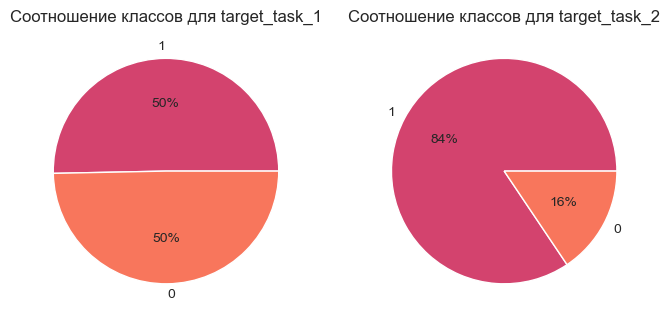

In [218]:
# Создадим временные таблицы дя визуализации 

df_6 = df['target_task_1'].value_counts()
df_7  = df['target_task_2'].value_counts()

colors = sns.color_palette('magma')[3:8]

plt.figure(figsize=(8, 6))

plt.subplot(1, 2, 1)
plt.pie(df_6, labels = df_6.index, colors = colors, autopct='%.0f%%')
plt.title('Соотношение классов для target_task_1')

plt.subplot(1, 2, 2)
plt.pie(df_7, labels = df_7.index, colors = colors,  autopct='%.0f%%')
plt.title('Соотношение классов для target_task_2')


plt.show()

### resume_id, vacancy_id & vacancy_company_id

In [219]:
get_columns_info(df, columns = ['resume_id', 'vacancy_id', 'vacancy_company_id'])

,count_na,"prec_na, %",n_unique
resume_id,0,0.0,240107
vacancy_id,0,0.0,158374
vacancy_company_id,0,0.0,22657


In [220]:
# Посмотрим сколько действительно уникальных резюме есть

resume_col = [x for x in df.columns if x[:6] == 'resume']
resume_col

['resume_id',
 'resume_position',
 'resume_salary_from',
 'resume_city_id',
 'resume_city_search_job',
 'resume_is_leaving',
 'resume_offer_education_id',
 'resume_is_foreign_language',
 'resume_is_upload_photo',
 'resume_offer_experience_year_count',
 'resume_region_id']

In [221]:
resume_df = df[resume_col]
resume_df.drop_duplicates(inplace=True) # Избавимся от возможных дубликатов
resume_df.shape

(240107, 11)

In [222]:
vacancy_col = [x for x in df.columns if x[:7] == 'vacancy']
vacancy_col

['vacancy_id',
 'vacancy_custom_position',
 'vacancy_operating_schedule_id',
 'vacancy_salary_from',
 'vacancy_salary_to',
 'vacancy_description',
 'vacancy_offer_education_id',
 'vacancy_offer_experience_year_count',
 'vacancy_company_id',
 'vacancy_is_agency',
 'vacancy_city_id',
 'vacancy_operating_schedule_comment',
 'vacancy_offer_experience_year_id']

In [223]:
# на всякий случай ине будем включать признаки с большой долей пропусков
# 'vacancy_operating_schedule_comment','vacancy_offer_experience_year_id'

vacancy_df = df[vacancy_col[:-2]] 
vacancy_df.drop_duplicates(inplace=True) # Избавимся от возможных дубликатов
vacancy_df.shape

# Судя по всему один и тот же id может быть у двух разных вакансий (с разными характеристиками)
# что всего уникальных vacancy_id 157 562, а по факту мы получили 208 133

(208133, 11)

In [224]:
# 'vacancy_company_id' имеет высокую кардинальность.
# Здесь необходимо будет принять решение удалить или кодировать данную переменную при помощи hashing encoder.
# Стоит признать, что хеширование допускает потери.
# Например 347 компаний , то в среднем 35 компаний будут получать один и тот же хэш в случае если их херировать на 10 корзин.
# Но когда альтернативой является отказ от переменной поскольку она слишком широкая по обхвату, 
# кодирование с потерями -приемлемый компромисс.

get_columns_info(df, columns = ['vacancy_company_id'])

,count_na,"prec_na, %",n_unique
vacancy_company_id,0,0.0,22657


### resume_position

resume_position - название резюме

In [225]:
# Напишем функцию, приводит строки к нижнему регистру
# Прибегать к лемматизации и стеммингу на данном этапе, я думаю не нужно
# Поскольку мы хотим полное название професии

def preprocess_proff(text):
    text = str(text).lower()  # добавим преобразование в строку, потому что при перевом запуске, возникла ошибка AttributeError 
    return text


df['resume_position'] = df['resume_position'].apply(preprocess_proff)

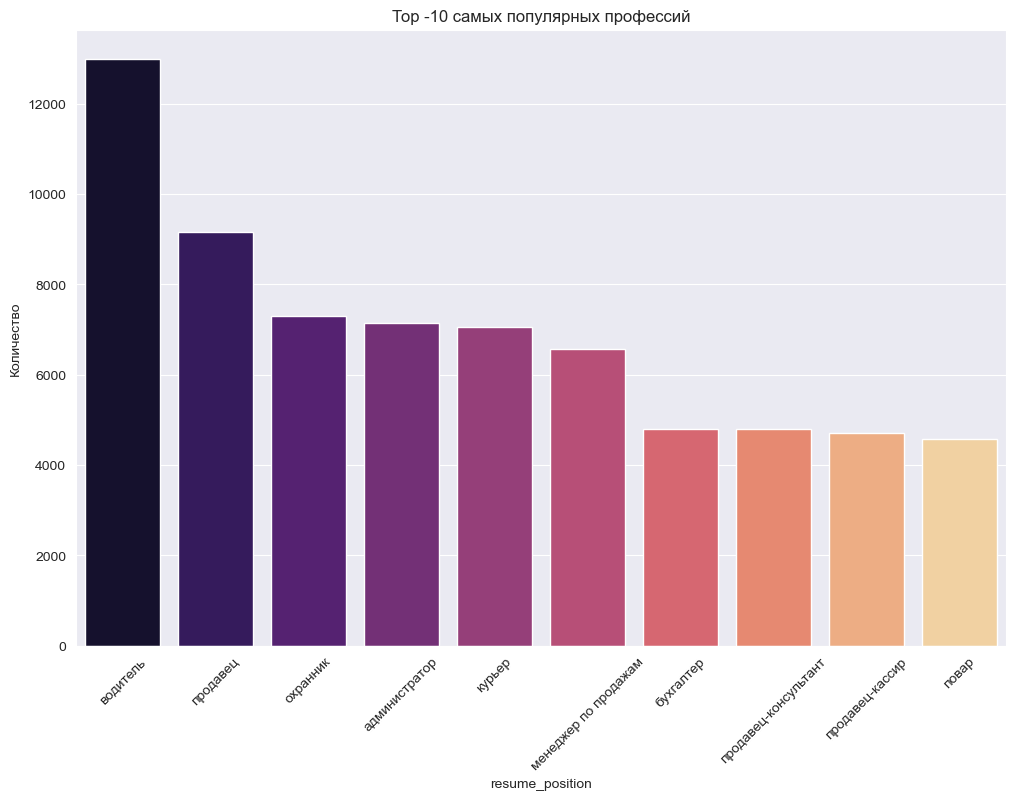

In [226]:
# Посмотрим на top-10 самых популярных профессий

jobs = df.groupby('resume_position').size().reset_index().sort_values(by=0, ascending = False)

plt.figure(figsize=(12,8))
sns.set_style("darkgrid")
sns.barplot(x='resume_position',y=0, data = jobs[:10],palette = 'magma')
plt.title('Тор -10 самых популярных профессий')
plt.xlabel('resume_position')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

#### WordCloud

Ещё одна визуализация с которой можно на самые часто встречающиеся вакансии

In [227]:
def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

def word_cloud(data, color_background, colormap, title):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=1200, 
               height=600, 
               max_words=50,
               colormap= colormap,
               max_font_size = 100,
               random_state=88, 
               background_color=color_background).generate_from_frequencies(data)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')

    plt.show()

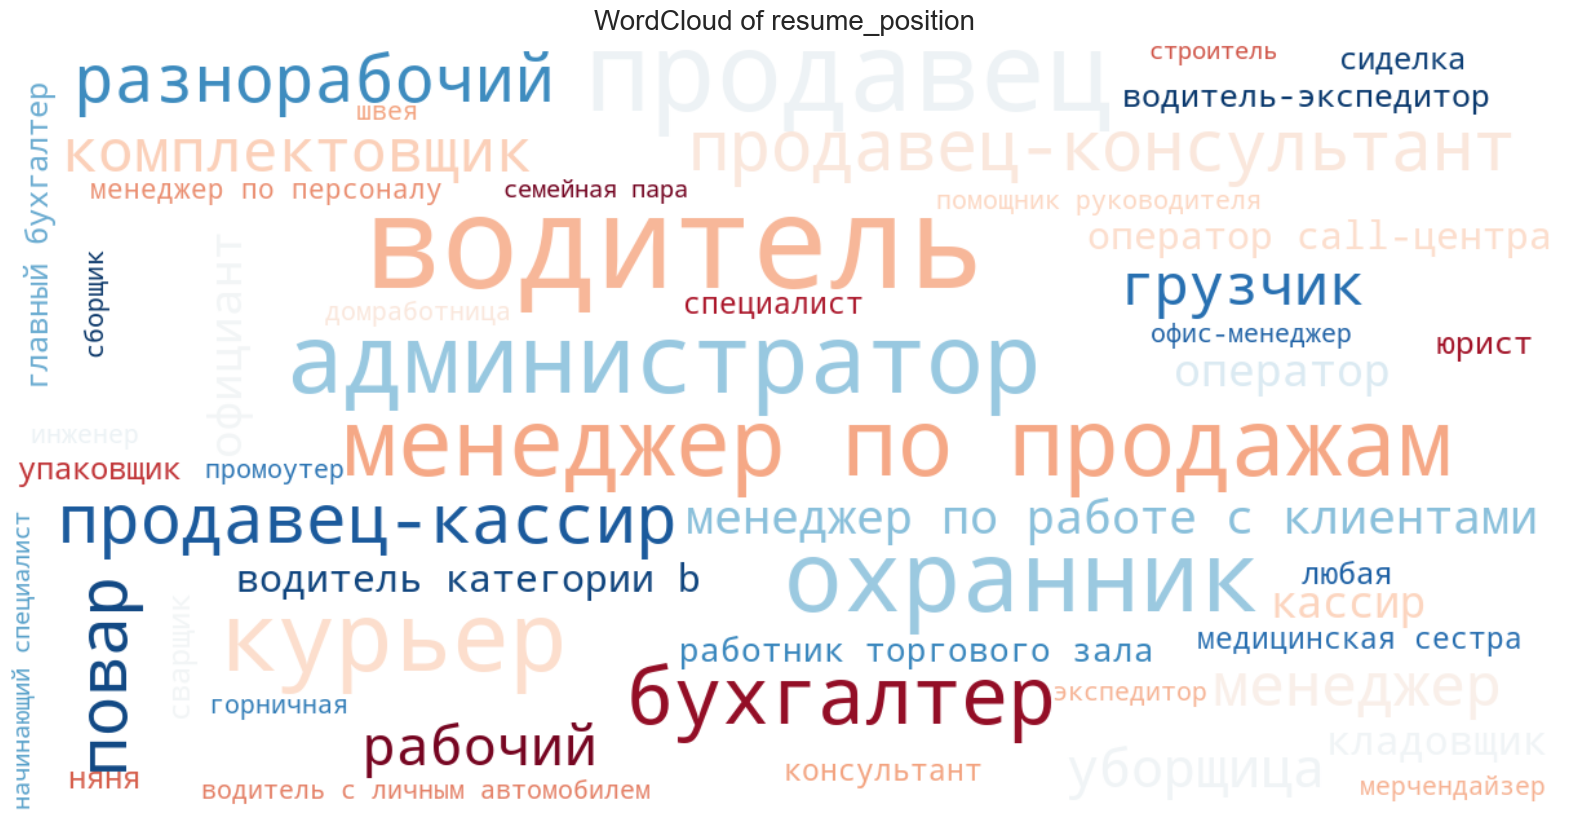

In [228]:
data_prof = df['resume_position'].values.tolist()

freq_df = Freq_df(data_prof)
data = dict(zip(freq_df['Term'].tolist(), freq_df['Frequency'].tolist()))
data = freq_df.set_index('Term').to_dict()['Frequency']

word_cloud(data ,'white','RdBu', 'WordCloud of resume_position')
# Так ещё лучше видно самые популярные профессии

### birth_date & resume_age

In [229]:
# Посмотрим на максимальный и минимальный возраст соискателей

df['birth_date'] = pd.to_datetime(df['birth_date'] , errors= 'coerce')
date_now = datetime.now()

df['resume_age'] = (date_now - df['birth_date']).astype('<m8[Y]')

# Мы получили новый признак 'resume_age'
# Пока больше идей как можно исползовать этот признак нет
# Поэтому сразу удалим его
df.drop(['birth_date'], axis=1, inplace= True) 

# Выведем максимальный и минимальный возраст
print(f'Максимальный возраст {df.resume_age.max()}')
print(f'Минимальный возраст {df.resume_age.min()}')

Максимальный возраст 123.0
Минимальный возраст 4.0


<Figure size 800x600 with 0 Axes>

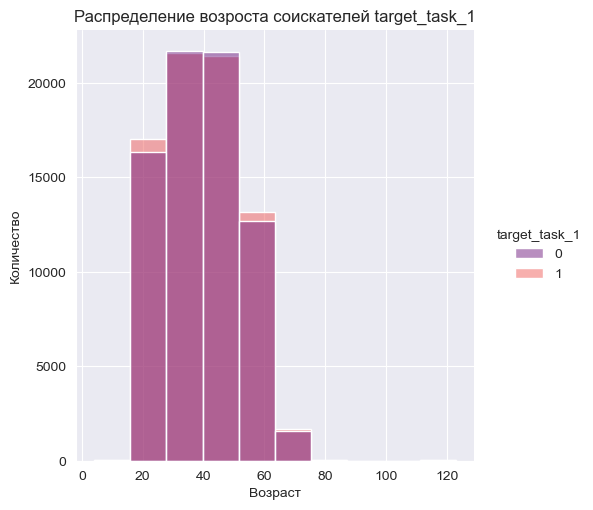

<Figure size 1000x800 with 0 Axes>

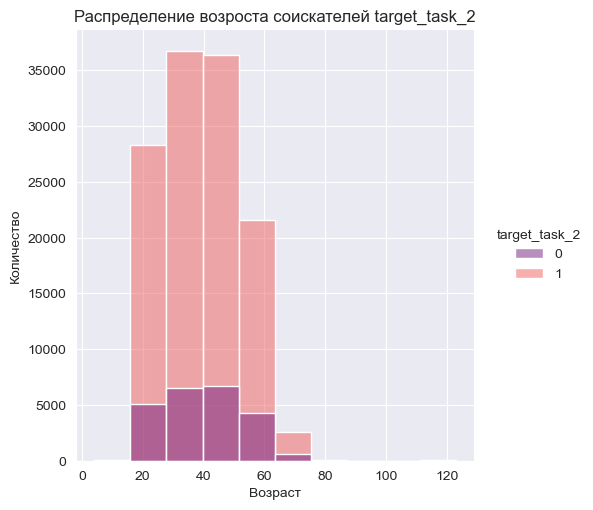

In [230]:
# Посмотрим на распределение возраста.
# И отметим, что распределение имеет тяжёлый правый хвост.
# Также отметим, что распределения относительно таргета похожи
# В случае target_task_2 это лучше увидеть при помощи boxplot, поскольку есть дисбаланс классов
# Я ожидала увидеть, что распределение по таргету будет смещённым. 
# Например, приглашения на собеседования приходят в большей степени более молодым соискателям.

plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')
sns.displot(data = df, 
            x ='resume_age',
            hue = 'target_task_1', 
            palette = 'magma',
           weights=0.5)
plt.title('Распределение возроста соискателей target_task_1')
plt.ylabel('Количество')
plt.xlabel('Возраст')


plt.figure(figsize=(10, 8))
sns.set_style('darkgrid')
sns.displot(data = df, 
            x ='resume_age',
            hue = 'target_task_2', 
            palette = 'magma',
           weights=0.5)
plt.title('Распределение возроста соискателей target_task_2')
plt.ylabel('Количество')
plt.xlabel('Возраст')

plt.show()



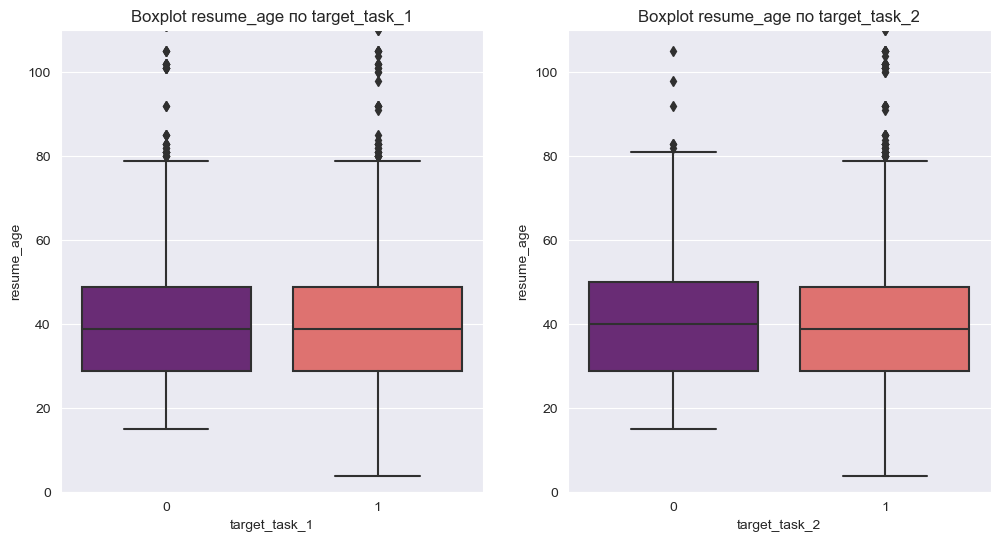

In [231]:
# Построим boxplot и увидим, что и для первой и для второй задачи распределения возраста одинаковые 
# за исключением единичных выбросов.
# Но если мы это постараемся поправить с помощью процентилей, то боюсь мы увидим очень похожую картину.

get_boxplot('resume_age', max_=110)

In [232]:
# Но перед тем как удалять выбросы нужно поработать с пропущенными значениями.
# Их не так много (48 пропущенных значений), поэтому я их удалю

get_columns_info(df, ['resume_age'])

,count_na,"prec_na, %",n_unique
resume_age,48,0.0161,94


In [233]:
df = df[df['resume_age'].isna() == False]

In [234]:
# Теперь можно удалить выбросы

high_prec = np.percentile(df['resume_age'].values, 99.0)
low_prec = np.percentile(df['resume_age'].values, 0.5)

# Подрезали данные: Оставили верхнюю грницу чуть больше пенсионного возраста мужчин
# и нижняя возраст, когда можно работать полный рабочий день

print(f'Верхняя граница : {high_prec}\nНижняя граница: {low_prec}')

df = df[(df['resume_age'] <= high_prec) & (df['resume_age'] >= low_prec)]


Верхняя граница : 67.0
Нижняя граница: 16.0


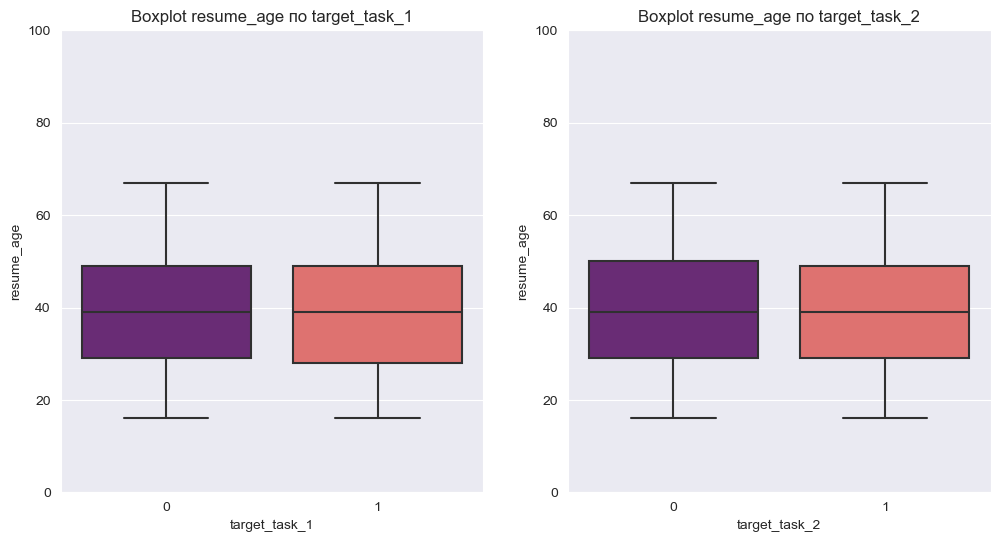

In [235]:
# Посмотрим ещё раз на boxplot и убедимся, что мы были правы, что признак не очень выразительный в плане влияния на таргет.
# В случае target_task_2 можно отметить 75-квантиль лежит чуть ниже 50 лет 

get_boxplot('resume_age', df, max_=100)

#  Ящики с усами от таргета не сильно изменяются, 
#  значит, можно сделать вывод, что  распределение признака не очень влияют на определение таргета.
# Но не будем горячится

В разрезе профессии водитель


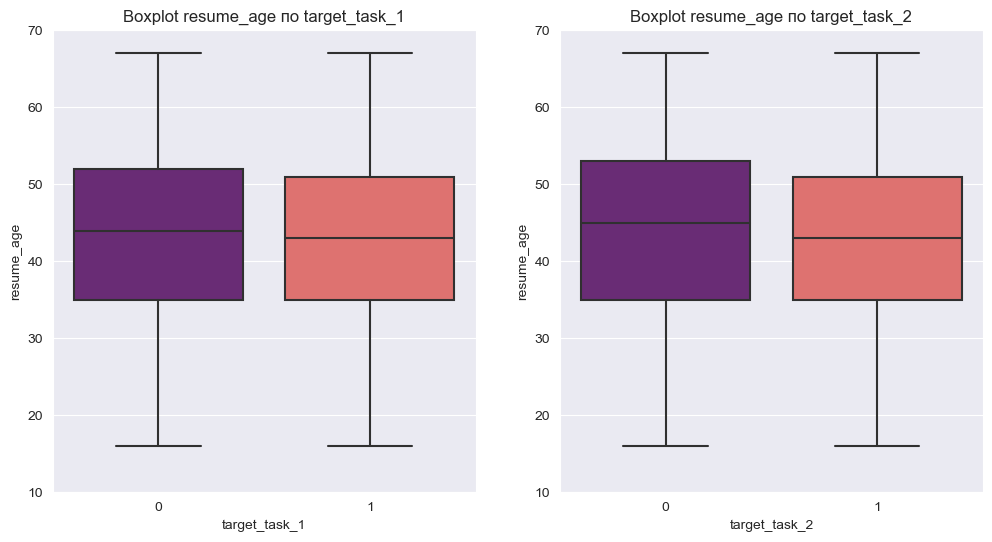

В разрезе профессии продавец


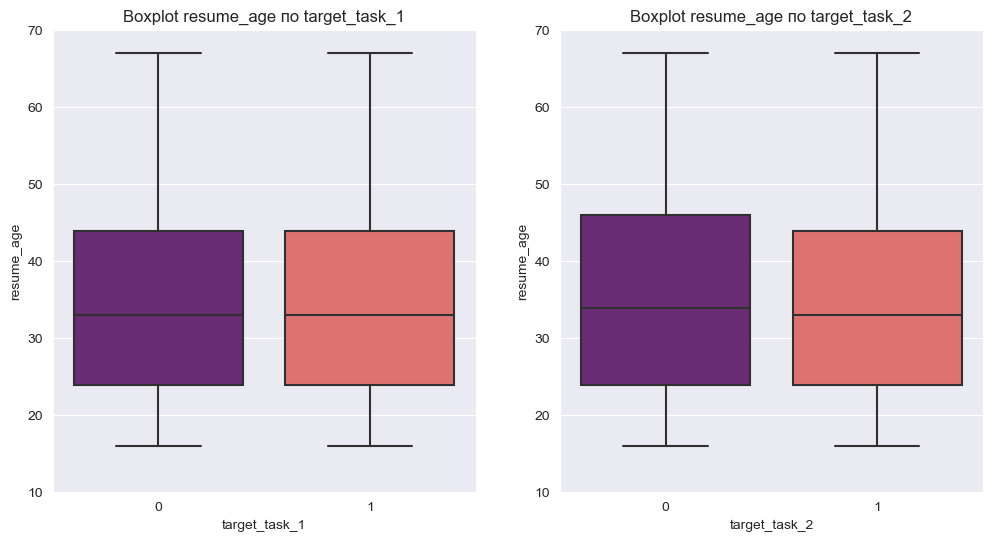

В разрезе профессии охранник


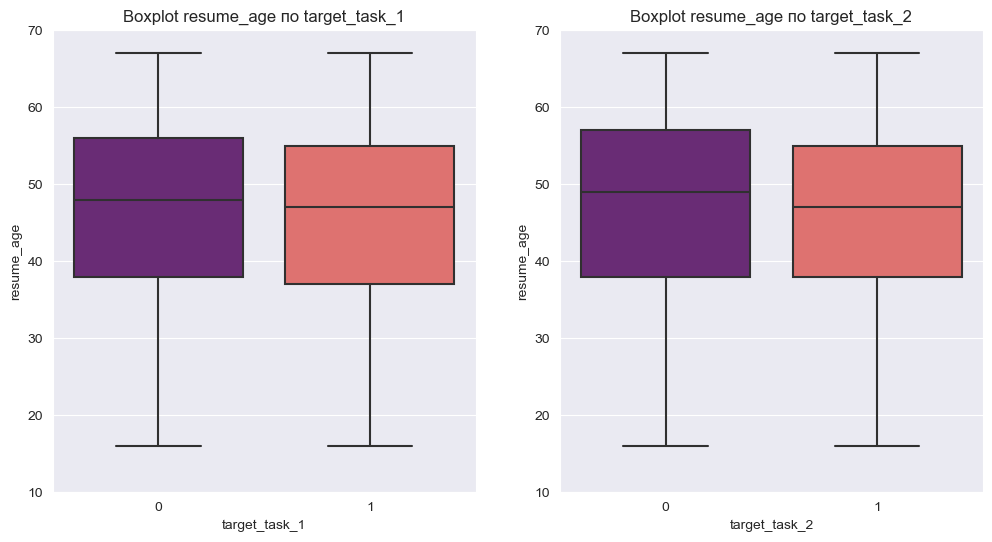

В разрезе профессии администратор


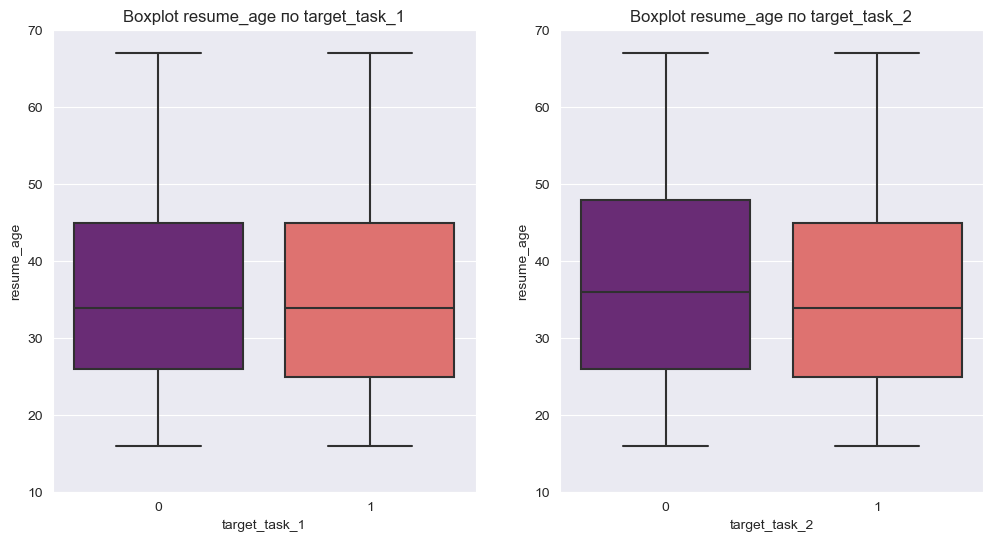

В разрезе профессии курьер


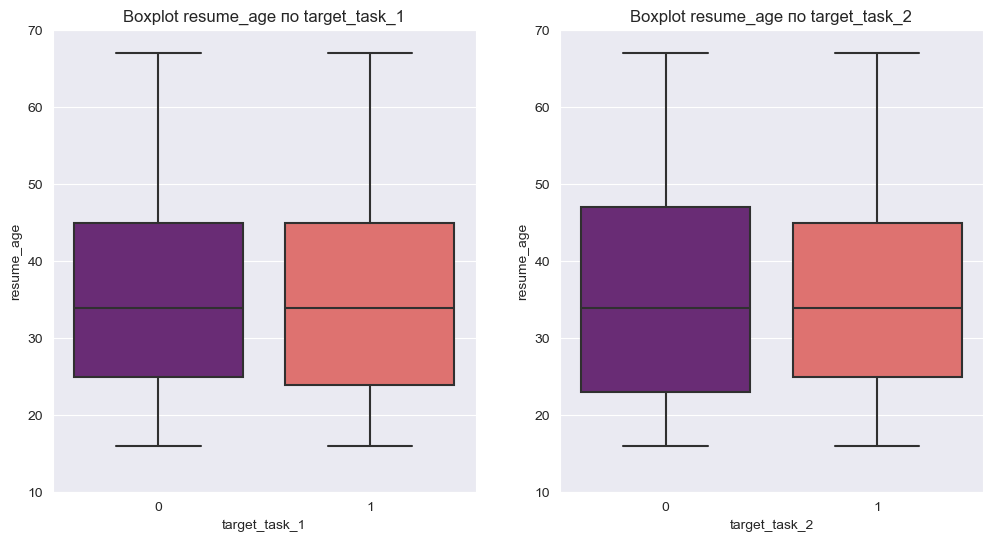

In [239]:
# Попробуем посмотреть в глубь  и посмотреть в разрезе профессий возьмём для примера 5 самых больших категорий

for i in ['водитель', 'продавец', 'охранник', 'администратор', 'курьер']:
    print(f'В разрезе профессии {i}')
    get_boxplot('resume_age', df =df[df['resume_position'] == i], min_ =10, max_=70)
    
# При таком разрезе,  можно увитеть более выразительныую картину
# В случаи Водителя, возможно для более чёткой картины следует учитывать ещё другие факторы, 
# возможно город и готовность к переезду
# Но главное, что мы убедились,что возраст может оказаться важным признаком
# Пример, профессии курьер по второму таргему, чтодиапозон приглашений на собеседование уже, чем у отказов

### resume_salary_from, vacancy_salary_from	 & vacancy_salary_to
__vacancy_salary_from__	

In [240]:
# Вспомним, сколько у нас пропущенных значений

get_columns_info(df, columns=['resume_salary_from', 'vacancy_salary_from', 'vacancy_salary_to'])

,count_na,"prec_na, %",n_unique
resume_salary_from,69822,23.6108,768
vacancy_salary_from,0,0.0000,1590
vacancy_salary_to,90720,30.6777,1419


In [241]:
df[['resume_salary_from', 'vacancy_salary_from', 'vacancy_salary_to']].describe()

# Самое интересное, что бросается в глаза - это минимальное значение 'vacancy_salary_from', 'vacancy_salary_to' оно отрицательное

,resume_salary_from,vacancy_salary_from,vacancy_salary_to
count,2.258980e+05,295720.000000,2.050000e+05
mean,4.487240e+04,40796.662427,6.038882e+04
std,1.716592e+05,28856.275043,5.540035e+04
min,0.000000e+00,-1.000000,-1.000000e+00
25%,2.700000e+04,25000.000000,3.500000e+04
50%,4.000000e+04,40000.000000,5.000000e+04
75%,6.000000e+04,55000.000000,8.000000e+04
max,7.000012e+07,900000.000000,3.000000e+06


In [242]:
# А заполнять пропуски, смотря на похожие объекты
# Например, ориентируясь на 'resume_position'
# Поставим в пропуски среднее значение

grouped_resume_salary_from = df.groupby(['resume_position'])['resume_salary_from'].transform('mean')
df['resume_salary_from'] = df['resume_salary_from'].fillna(grouped_resume_salary_from)

get_columns_info(df, columns=['resume_salary_from'])

,count_na,"prec_na, %",n_unique
resume_salary_from,5423,1.8338,2130


In [243]:
# Остаток пропусков, которые не получилось заполнить - удалим

df = df[df['resume_salary_from'].isna() == False]

In [244]:
# Что делать с vacancy_salary_to .
# Можно предположжить Два варианта:
# 1. Простой путь : Просто дропнуть ибо он сильно коррелирует с 'vacancy_salary_from' и зачем нам ещё один признак, 
# часть информации которого мы можем выразить через другой и без пропусков

# 2.Сложный: Либо постараться воcстановить пропущенные значения одним из возможных методов(предсказать при помощи регресси, 
# заполнить средними значения похожих объектов и т.д)  и сгенерить совместный признак с 'vacancy_salary_to'
# - например среднее вместо двух 'vacancy_salary_from' и 'vacancy_salary_to'

# Но мы пойдем простым путём.

df[['resume_salary_from', 'vacancy_salary_to', 'vacancy_salary_from']].corr()

,resume_salary_from,vacancy_salary_to,vacancy_salary_from
resume_salary_from,1.000000,0.081616,0.062357
vacancy_salary_to,0.081616,1.000000,0.630987
vacancy_salary_from,0.062357,0.630987,1.000000


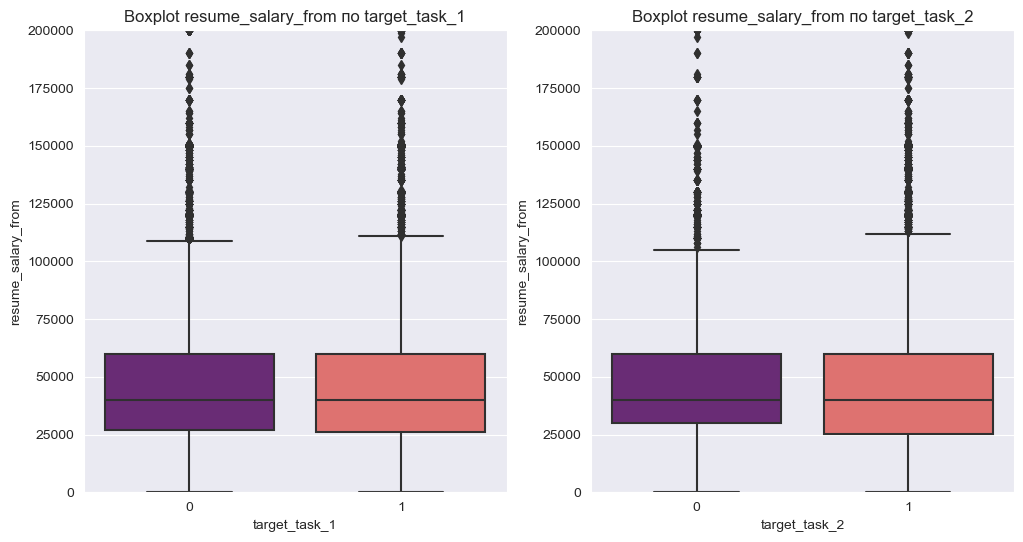

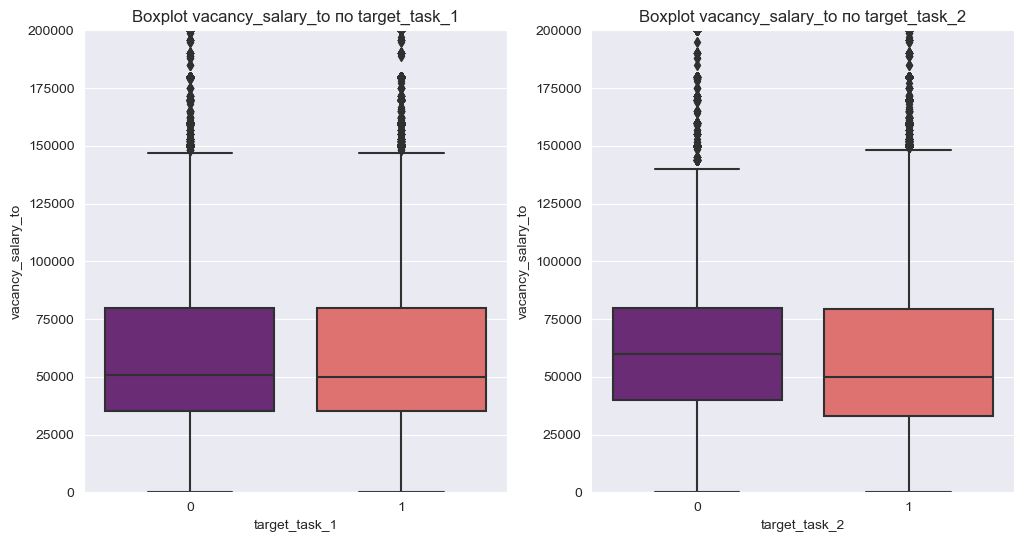

In [245]:
for col in ['resume_salary_from', 'vacancy_salary_to']:
    get_boxplot(col)

# Отметим, что во всех случаях очень много выбросов
# Распределения'vacancy_salary_to' по target_task_2 отличаются : среднее таргета 1  меньше таргета 0, и оно шире. 
# Можно сказать, что чаще приглашают на собеседования на вакансии с зарплатой 50000.

In [246]:
# Удаление выбросов

high_prec = np.percentile(df['vacancy_salary_from'].values, 99)
# low_prec = np.percentile(df['vacancy_salary_from'].values, 1)

df = df[df['vacancy_salary_from']<= high_prec]


### resume_city_id, resume_region_id & vacancy_city_id

__resume_city_id__ - id города соискателя 

__resume_region_id__ - идентификатор региона резюме

__vacancy_city_id__ - id города работодателя

 Сравнить с resume_city_id и посмотреть сколько людей ищат работу в других городах

In [247]:
get_columns_info(df, ['resume_city_id', 'resume_region_id', 'vacancy_city_id'])

,count_na,"prec_na, %",n_unique
resume_city_id,0,0.00,93
resume_region_id,144,0.05,2294
vacancy_city_id,0,0.00,67


In [248]:
# А давайте будем заполнять пропуски, смотря на похожие объекты
# Например, ориентируясь на 'vacancy_city_id' и 'resume_city_id'
# Поставим в пропуски самое часто встречающееся значение

grouped_value = df.groupby(['vacancy_city_id', 'resume_city_id'])['resume_region_id'].transform(lambda x: x.value_counts().index[0])

df['resume_region_id'] = df['resume_region_id'].fillna(grouped_value)


# Проверим все ли пропуски перекрыли

get_columns_info(df, ['resume_city_id', 'resume_region_id', 'vacancy_city_id'])

,count_na,"prec_na, %",n_unique
resume_city_id,0,0.0,93
resume_region_id,0,0.0,2294
vacancy_city_id,0,0.0,67


In [249]:
#  Приведем к одному типу данных для красоты.
# Потому что 'vacancy_city_id' типа int, 'resume_city_id' nbgf float

df['resume_city_id'] = df['resume_city_id'].astype(int)

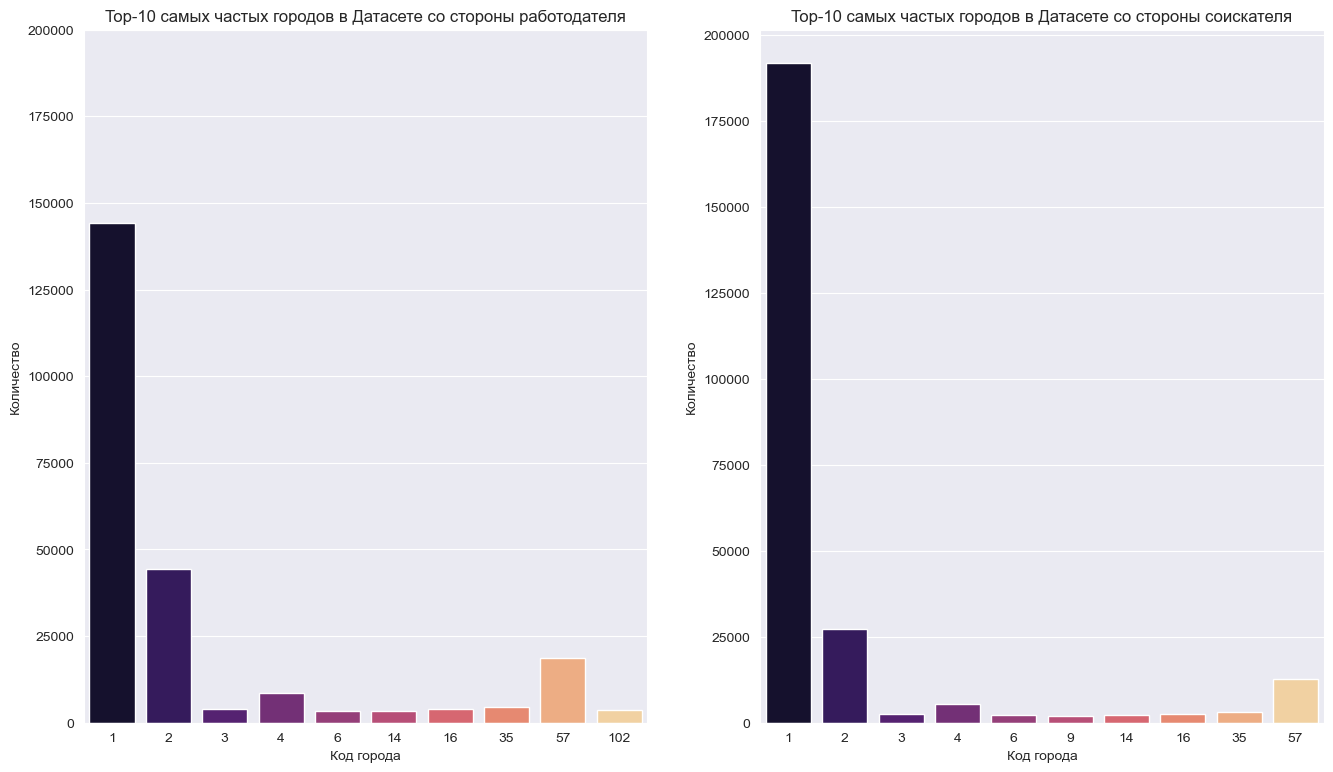

(0.0, 200000.0)

In [250]:
# Тор-10 самых частых городов в Датасете со стороны работодателя и соискателя

plt.figure(figsize=(16, 9))


df_1 = pd.DataFrame(df['vacancy_city_id'].value_counts()).reset_index()[:10]

plt.subplot(1, 2, 1)
sns.set_style('darkgrid')
a = sns.barplot(x ='index', y = 'vacancy_city_id', data =df_1, palette = 'magma')
plt.title("Top-10 самых частых городов в Датасете со стороны работодателя")
plt.ylabel('Количество')
plt.xlabel('Код города')
a.set_ylim(0,200000)


# Тор-10 самых частых городов в Датасете


df_2 = pd.DataFrame(df['resume_city_id'].value_counts()).reset_index()[:10]

plt.subplot(1, 2, 2)
sns.set_style("darkgrid")
b = sns.barplot(x ='index', y = 'resume_city_id', data =df_2, palette = 'magma')
plt.title("Top-10 самых частых городов в Датасете со стороны соискателя")
plt.ylabel('Количество')
plt.xlabel('Код города')
plt.show()
b.set_ylim(0,200000)

# Видно, что топ как состороны соискателя так и со стороны работодателя частично совпадают, 
# но наводит на мысль, что где-то в каких то городах может быть переизыток вакансий, а где-то наоборот работников.

# Проверим есть ли города соискателей, которых нет у работодателей. 
# Судя по количеству уникальных id_city в любом случаи мы найдем расхождение.

In [251]:
# Среди соискателей встречаются резюме с кодом города, с которым нет вакансий.

unique_resume_city = df.resume_city_id.unique()
unique_vacancy_city = df.vacancy_city_id.unique()

resume_city_mask = np.in1d(unique_resume_city, unique_vacancy_city)

# id городов жители , которых ищут работу в дргих города - датасете нет вакансий в этих городах

empty_vacancy_city = unique_resume_city[resume_city_mask ==False]

empty_vacancy_city


# Также из-за случайности отбора вполне возможно , что тренироваочные данные  не будут содержать все возможные id_city. 
# Словарь может оказаться неполным.

# При такой истории у нас нет гарантий, что новые категории не будут появлятся в процессе использования модели. 
# При этом возникнет проблема холодного старта.

# Поэтому для кодирования таких признаком нужно использовать hashing encoder



array([ 40, 262, 280, 279,  39,  23,  65, 147,  68,  66, 196, 110,  85,
        56,  21,  80, 144,  96,  45, 108,  53,  95, 178,  78,  31, 146])

In [252]:
# В противном случае , во всех городах, где ищат работников, есть люди, которые ищат работу

vacancy_city_mask = np.in1d(unique_vacancy_city, unique_resume_city)


unique_vacancy_city[vacancy_city_mask == False]

# Можно косвено сделать выводы о дефеците вакансий в некоторых городах. 
# Не будем вывдить все возможные варианты городов. 
# Всё равно всё на графике не увидем: выведем 

array([], dtype=int64)

<AxesSubplot:xlabel='resume_city_id', ylabel='count'>

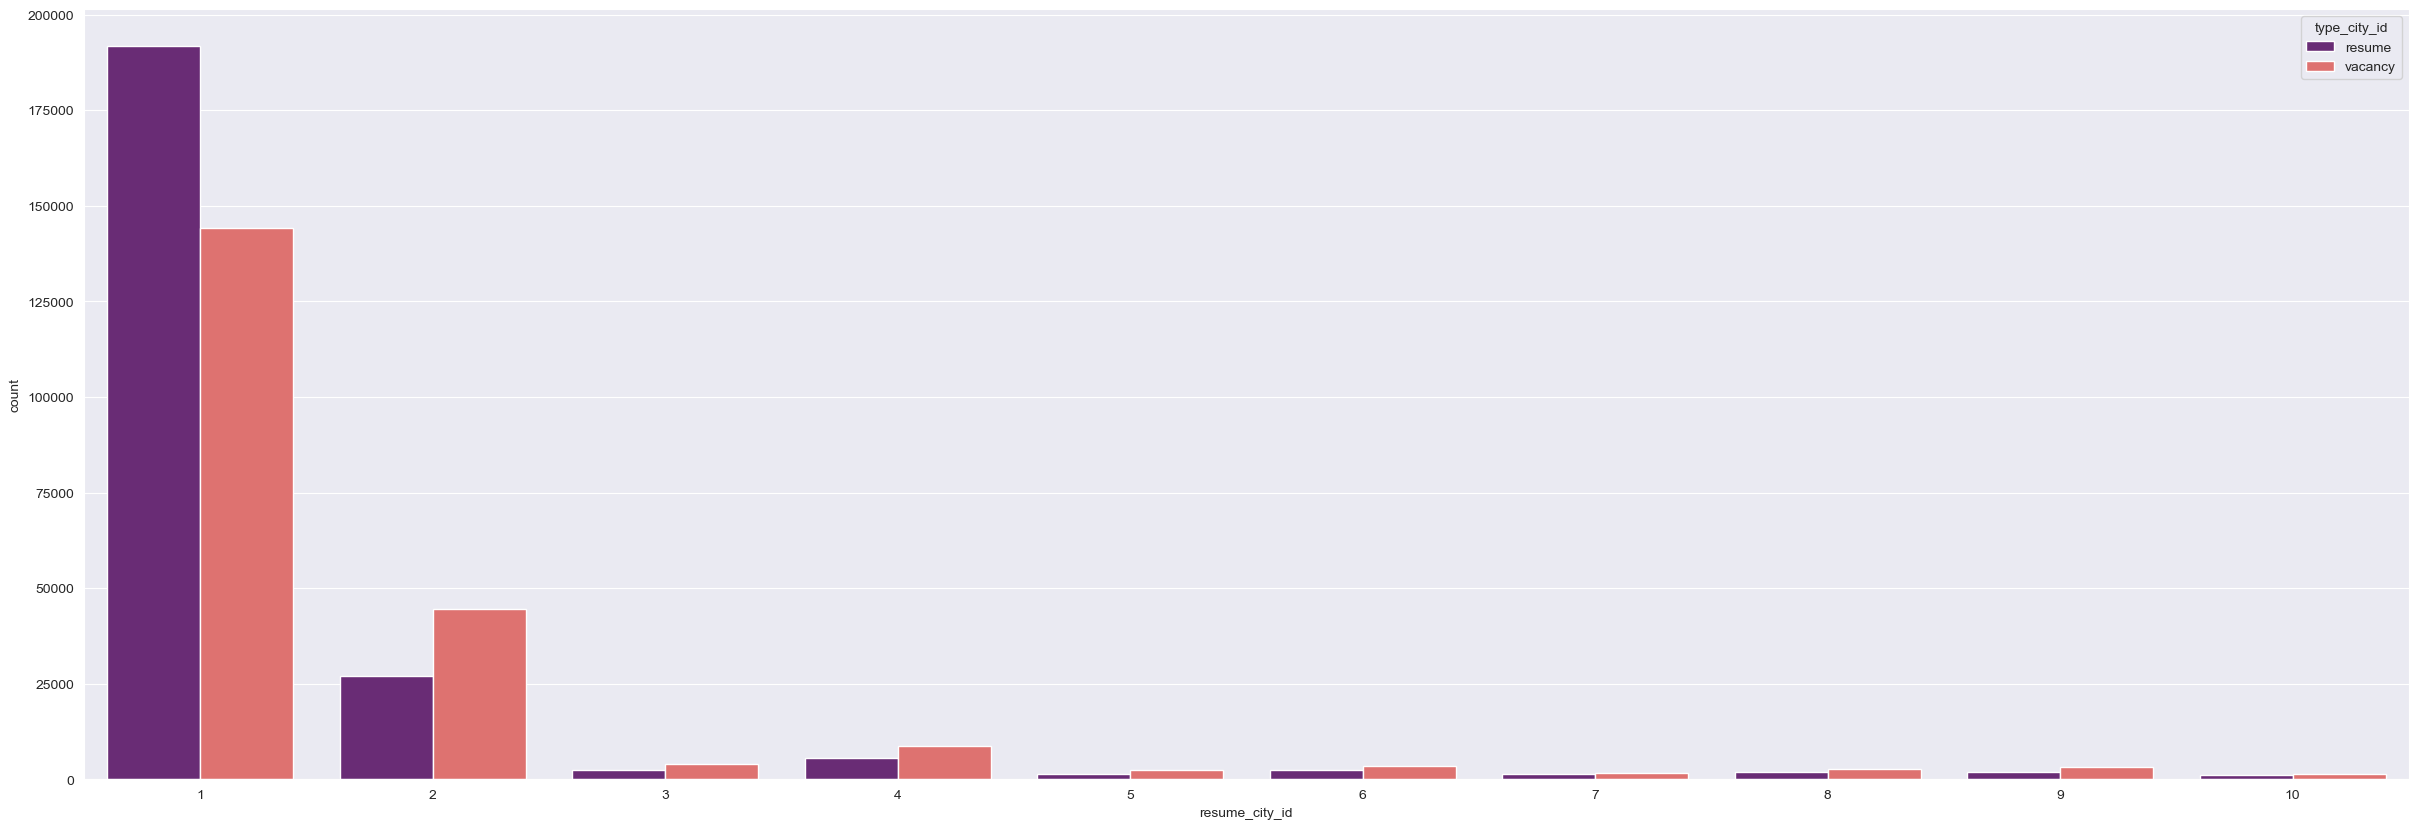

In [42]:
# Создадим временную таблицу для визуализации соотношения количества вакансий 
# по городам, чтобы понять где есть дефецит и профицит резюме.
 
df_3 = df.groupby('vacancy_city_id', as_index=True).agg({'vacancy_city_id' :'count'}).rename(columns={'vacancy_city_id' : 'count_vacancy'})

 
df_4 = df.groupby('resume_city_id', as_index=True).agg({'resume_city_id' : 'count'}).rename(columns={'resume_city_id' : 'count_resume'})


df_5 = df_4.join(df_3, how ='left').fillna(0).reset_index()
ddf_5 = df_5[['resume_city_id', 'count_resume']].rename(columns={'count_resume': 'count'})
ddf_5['type_city_id'] = 'resume'

dff_5 = df_5[['resume_city_id','count_vacancy']].rename(columns={'count_vacancy': 'count'})
dff_5['type_city_id'] = 'vacancy'

df_5  = pd.concat([ddf_5, dff_5], axis=0, ignore_index=True).sort_values(by='resume_city_id')[:20]

plt.figure(figsize=(30,10))
sns.barplot(data=df_5, x='resume_city_id', y='count', hue = 'type_city_id', palette='magma')

# Видим, что резюме с city_id 1, больше чем вакансий, которые попали в дата сет
# По дркгим городам картина обратная.

### resume_offer_education_id & vacancy_offer_education_id

In [253]:
# Посмотрим на пропуски и иколичество уникальных значений
# Видим, что  есть 27% пропусков

get_columns_info(df, ['resume_offer_education_id', 'vacancy_offer_education_id'])

,count_na,"prec_na, %",n_unique
resume_offer_education_id,79017,27.4598,16
vacancy_offer_education_id,0,0.0000,8


In [254]:
#  Посмотрим на количество каждой категории

df['resume_offer_education_id'].value_counts()

4.0     72128
1.0     50047
2.0     46668
3.0     15149
5.0      8469
6.0      8420
8.0      2877
7.0      1667
14.0     1586
0.0       626
11.0      490
9.0       326
12.0      228
15.0       31
13.0       14
10.0       12
Name: resume_offer_education_id, dtype: int64

(0.0, 100000.0)

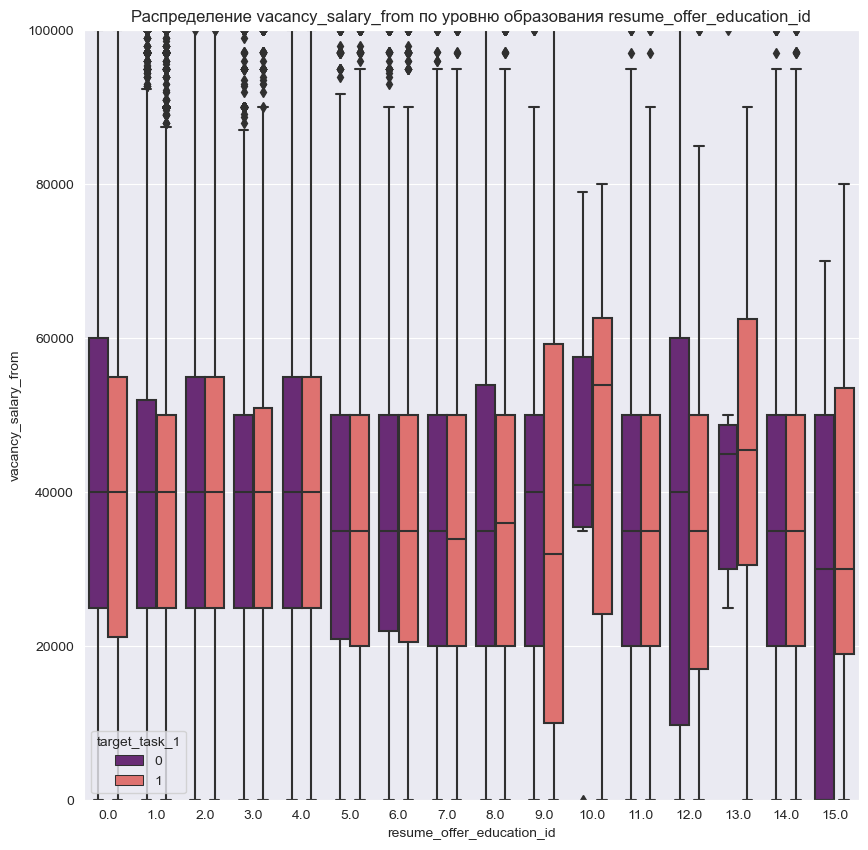

In [255]:
# Посмотрим на распостранение зарплат по отношению уровня образования

plt.figure(figsize=(10, 10))

a = sns.boxplot(data = df, y = 'vacancy_salary_from', x = 'resume_offer_education_id',  hue= 'target_task_1', palette='magma')
plt.title('Распределение vacancy_salary_from по уровню образования resume_offer_education_id')
a.set_ylim(0,100000)

# Запрашиваемы уровень зарплат от уровня образования разнится
# В диапазоне id 9 -15 по target_task_1 о можно отметить сильные различия распределений
# Например в случае id 10 - при этом уровне образования  в среднем соискателям интереснее вакансии с зп. на 10-12 тыс больше,
# Чем средняя зартплата без отклика.
# Когла в других случаях, что уровень зарплаты по уровню образования не является главным фактором для отклика. 
# Поскольку и в случаи отклика и 
# в случаи игнора средняя зарплата на одном уровне (0, 1, 2, 3, 4)

(0.0, 300000.0)

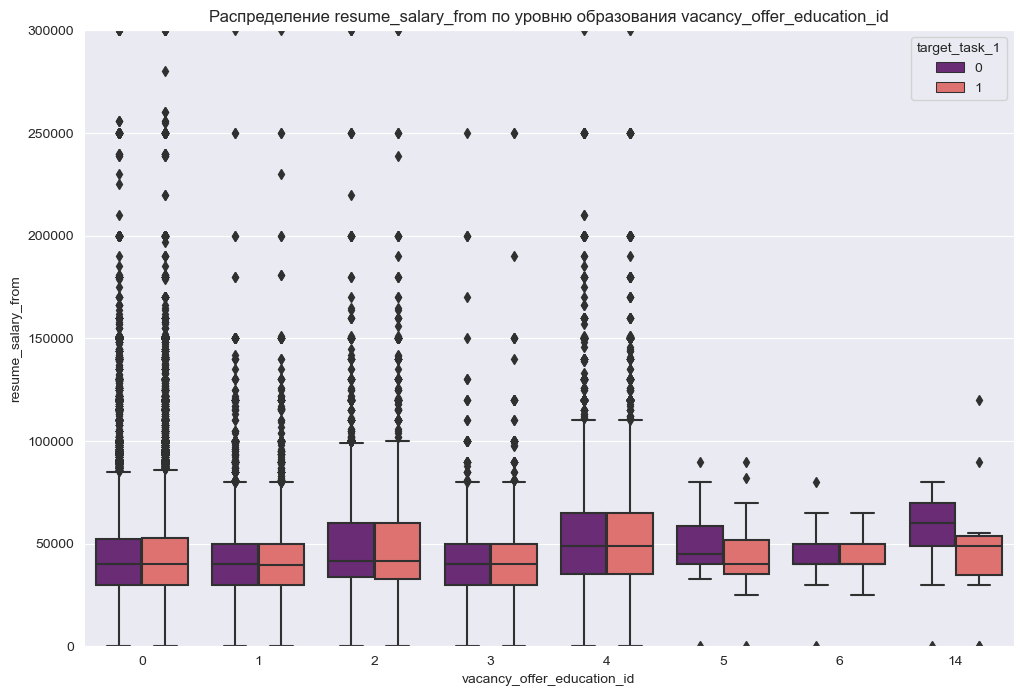

In [46]:
# Посмотрим на распостранение зарплат по отношению уровня образования

plt.figure(figsize=(12, 8))

a = sns.boxplot(data = df, y = 'resume_salary_from', x = 'vacancy_offer_education_id', hue ='target_task_1',palette= 'magma')
plt.title('Распределение resume_salary_from по уровню образования vacancy_offer_education_id')
a.set_ylim(0,300000)


# В 'vacancy_offer_education_id' представлены не все категории образования, что 'resume_offer_education_id'.
# Но 'vacancy_offer_education_id' видно различение в предологаемом уровне зарплат от уровня образования

In [47]:
# Предположим, что в 'resume_offer_education_id' представлены  все категории (16). 
# Заполним пропуски новой категорией

df['resume_offer_education_id'] = df['resume_offer_education_id'].fillna(17)


# Проверим все ли пропуски перекрыли

get_columns_info(df, ['resume_offer_education_id'])

,count_na,"prec_na, %",n_unique
resume_offer_education_id,0,0.0,17


### resume_offer_experience_year_count & vacancy_offer_experience_year_count

__resume_offer_experience_year_count__ - предположительный опыт работы соискателя в годах

__vacancy_offer_experience_year_count__ - необходимый предположительный опыт работы в годах для работодателя

In [48]:
# Во-первых, вспомним, что мы отмечали большой процент пропусков 
# resume_offer_experience_year_count

get_columns_info(df, ['resume_offer_experience_year_count', 'vacancy_offer_experience_year_count'])

,count_na,"prec_na, %",n_unique
resume_offer_experience_year_count,131298,45.6282,43
vacancy_offer_experience_year_count,23279,8.0898,13


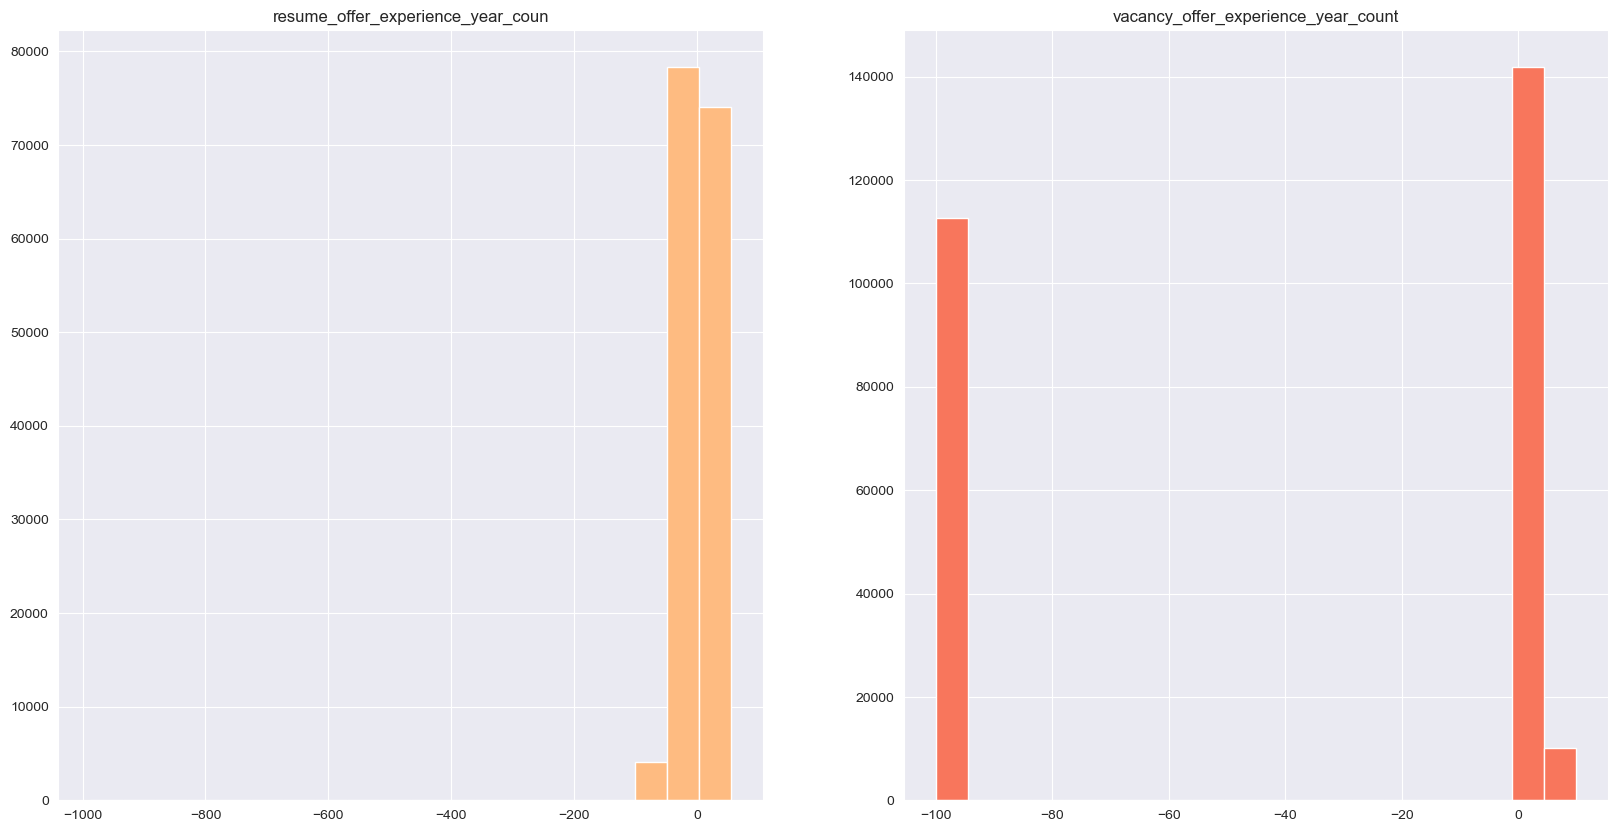

In [49]:
plt.figure(figsize=(20,10))

plt.subplot(1, 2, 1)
plt.hist(df.resume_offer_experience_year_count, bins = 20, color=colors[2])
plt.title('resume_offer_experience_year_coun')


plt.subplot(1, 2, 2)
plt.hist(df.vacancy_offer_experience_year_count, bins = 20, color=colors[1])
plt.title('vacancy_offer_experience_year_count')
plt.show()

In [50]:
# Не совсем понятен смысле этого признака.
# Судя по распределению, данные признаки записываются не верно, как со стороны соискателя, так и со стороны работодателя.
# Возможно, это больше должна быть категориальная фича: 'нет_опыта-1_год', '1_год-3_года' и т.д.
# Ил ипросто неотрицательная вещественная величина.


df[['resume_offer_experience_year_count', 'vacancy_offer_experience_year_count']].describe()

,resume_offer_experience_year_count,vacancy_offer_experience_year_count
count,156458.000000,264477.000000
mean,-0.499501,-41.799332
std,16.778411,50.110857
min,-987.000000,-100.000000
25%,-1.000000,-100.000000
50%,2.000000,-1.000000
75%,5.000000,1.000000
max,55.000000,10.000000


In [206]:
# По идее в случаи положительного таргета,эти признаки должны сильно коррелировать.

# Рассмотрим ситуация совпадения двух таргетов: соискатель откликнулся на вакансию ('target_task_1'==1)
# и рекрутер пригласил соискателя на работу ('target_task_2'==1)

# И логика заключается в том, что в идеальном случае кандитат, обладая необходым опытом откликается на вакансию и в тоже время
# интересен рекрутеру(поскольку удовлетворяет условиям отбора).
# И ожидается , что коэффициент корреляции, как показатель обозначающий силу и характер взаимосвязи между двумя переменным, 
# должен быть высокий.
# Ожидаемого эффекта мы не получили. Коэффициент корреляции близок к нулю.
# Поэтому лучше избавится от этих признаков


df_9 = df[(df['target_task_1']==1) & (df['target_task_2']==1)][['resume_offer_experience_year_count',
                                    'vacancy_offer_experience_year_count']]

get_top_abs_correlations(df_9)

resume_offer_experience_year_count  vacancy_offer_experience_year_count    0.070253
dtype: float64

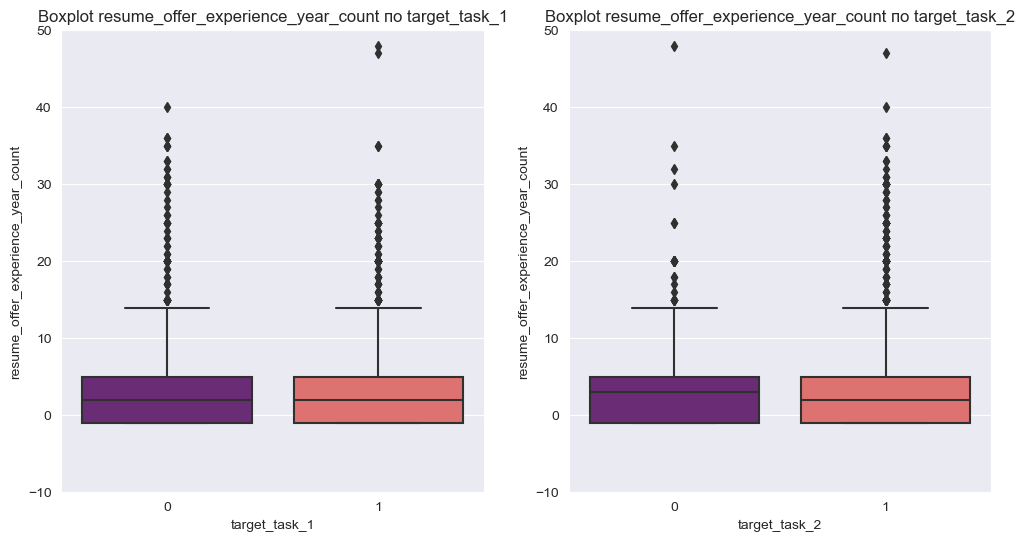

In [56]:
plt.figure(figsize =(12, 6))
        
plt.subplot(1, 2, 1)
a = sns.boxplot(y='resume_offer_experience_year_count', x=df['target_task_1'].astype('category'), data=df, palette = 'magma')
plt.title(f'Boxplot resume_offer_experience_year_count по target_task_1')
a.set_ylim(-10,50)

        
plt.subplot(1, 2, 2)
b = sns.boxplot(y='resume_offer_experience_year_count', x=df['target_task_2'].astype('category'), data=df, palette = 'magma')
plt.title(f'Boxplot resume_offer_experience_year_count по target_task_2')
b.set_ylim(-10,50)

plt.show()


### resume_city_search_job, resume_is_leaving , resume_is_foreign_language, resume_is_upload_photo & vacancy_is_agency

Все булевые признаки

In [57]:
bool_features = df.select_dtypes(include=['bool']).columns

In [58]:
# Посмотрим на квазиконстантые признаки
# Если дисперсия мала(допустим, равна нулю), то значения признака практически не меняются. 
# Такие признаки от объекта к объекту не меняются, поэтому их стоит убрать из выборки.

# Под капотом данного класса вычисляются все дисперсии 
# и убираются те признаки, у которых дисперсии ниже установленного порога threshold

cutter = VarianceThreshold(threshold=0.05)
cutter.fit(df[bool_features])

cutter.get_feature_names_out()

array(['resume_city_search_job', 'resume_is_leaving',
       'resume_is_upload_photo', 'vacancy_is_agency'], dtype=object)

In [59]:
# НО  надо помнить. что с бинарными признакми нужно быть аккуратнее.
# Поскольку дисперссия тем меньше, чем меньше порядок чисел
# Посмотрим внимательнее на соотношения True и False внутри каждого признака

for col in bool_features:
    print(df[col].value_counts())

#  и в принципе, можно согласиться с оставшимися признаками.

False    271842
True      15914
Name: resume_city_search_job, dtype: int64
False    221655
True      66101
Name: resume_is_leaving, dtype: int64
False    282300
True       5456
Name: resume_is_foreign_language, dtype: int64
False    211876
True      75880
Name: resume_is_upload_photo, dtype: int64
False    256798
True      30958
Name: vacancy_is_agency, dtype: int64


In [60]:
# Перезапишем
bool_features = cutter.get_feature_names_out()

### vacancy_description 

In [84]:
# Создать лемматизатор и список стоп-слов

mystem = Mystem() 
russian_stopwords  = stopwords.words("russian")

wnl = WordNetLemmatizer()
word_tokenaizer = nltk.WordPunctTokenizer()

snowball = SnowballStemmer(language='russian')


def preprocess_tfidf(text):
    tokens = mystem.lemmatize(str(text).lower())
    tokens = [word for word in tokens if re.match(r'[а-яА-Я]+', word)]
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " "] 
    tokens = [snowball.stem(token) for token in tokens]      
    out_text = ''
    for word in tokens:
        out_text += word + ' '
    if len(out_text) <3:
        out_text = 'пуст'
    return out_text
# КОСТЫЛЬ:  в случае, если preprocess_tfidf очистит строку полностью, 
# чтобы  не было ValueError: empty vocabulary; perhaps the documents only contain stop words

In [63]:
# Проверимю Было:

test_text = df['vacancy_description'][1]
test_text

'В связи с расширением распределительного центра бытовой техники приглашаем сотрудников!<br />\r\n<strong>ПРЕДЛАГАЕМ:</strong><br />\r\n<ul>\r\n<li>Вахта от 35 рабочих смен;</li>\r\n<li>Официальное оформление;</li>\r\n<li>Бесплатное комфортное общежитие, в шаговой доступности от объекта;</li>\r\n<li>Еженедельные авансы;</li>\r\n<li>Обучение принципам работы;</li>\r\n<li>Заселение в общежитие и трудоустройство в день обращения!</li>\r\n</ul>\r\n<strong>ОБЯЗАННОСТИ:</strong><br />\r\n<ul>\r\n<li>Упаковка / укладка готовой продукции в коробки;</li>\r\n<li>Погрузка-разгрузка, перемещение товара по участку;</li>\r\n</ul>\r\n<strong>ТРЕБОВАНИЯ:</strong><br />\r\n<ul>\r\n<li>Пунктуальность, ответственность, внимательность;</li>\r\n<li>Рассматриваем без опыта, обучим всему!</li>\r\n</ul>'

In [64]:
# Cтало:

preprocess_tfidf(test_text)

'связ расширен распределительн центр бытов техник приглаша сотрудник предлага вахт рабоч смен официальн оформлен бесплатн комфортн общежит шагов доступн объект еженедельн аванс обучен принцип работ заселен общежит трудоустройств ден обращен обязан упаковк укладк готов продукц коробк погрузк разгрузк перемещен товар участок требован пунктуальн ответствен внимательн рассматрива оп обуча ве '

In [203]:
#  Получим в качестве признака кластер по описанию вакансий
# выделем 30 кластеров

vacancy_describtion = df['vacancy_description']

pipe_1  = Pipeline([('vectorizer', TfidfVectorizer(max_features=5000, preprocessor=preprocess_tfidf)),
                    ('kmeans', KMeans(n_clusters=30, random_state=17))] , memory="tmp/dir")

kmeans = pipe_1.fit(vacancy_describtion)
df['TextCluster'] = kmeans.predict(vacancy_describtion)


In [66]:
# Технический момент
# Здесь я подгружаю уже полученные кластеры (чтобы не переобучать модель)

df2 = pd.read_csv('df.csv')
df = df.join(df2['TextCluster'], how = 'left')

#### WordCloud

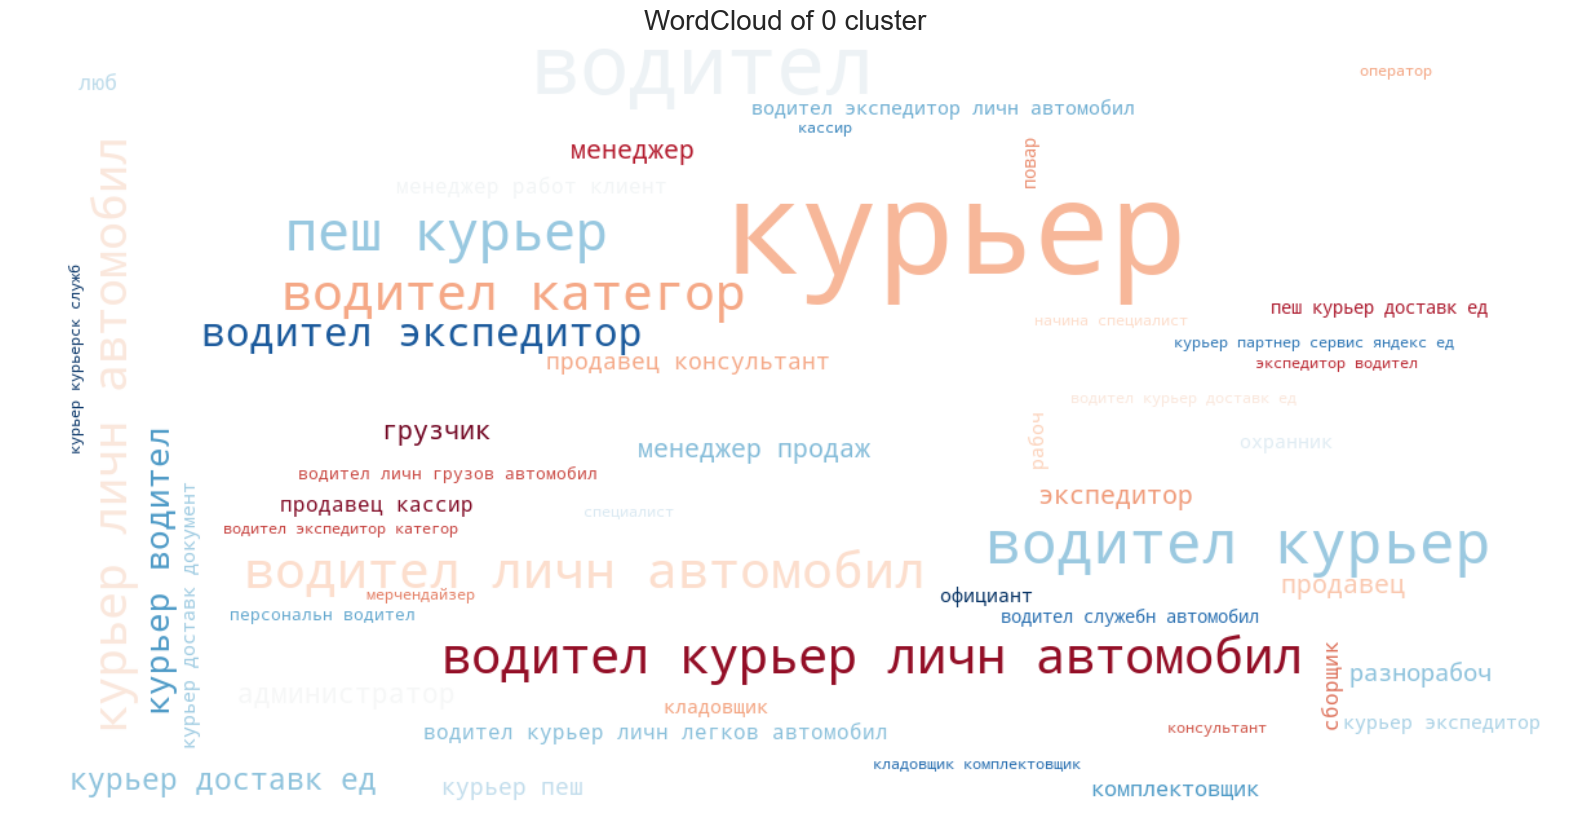

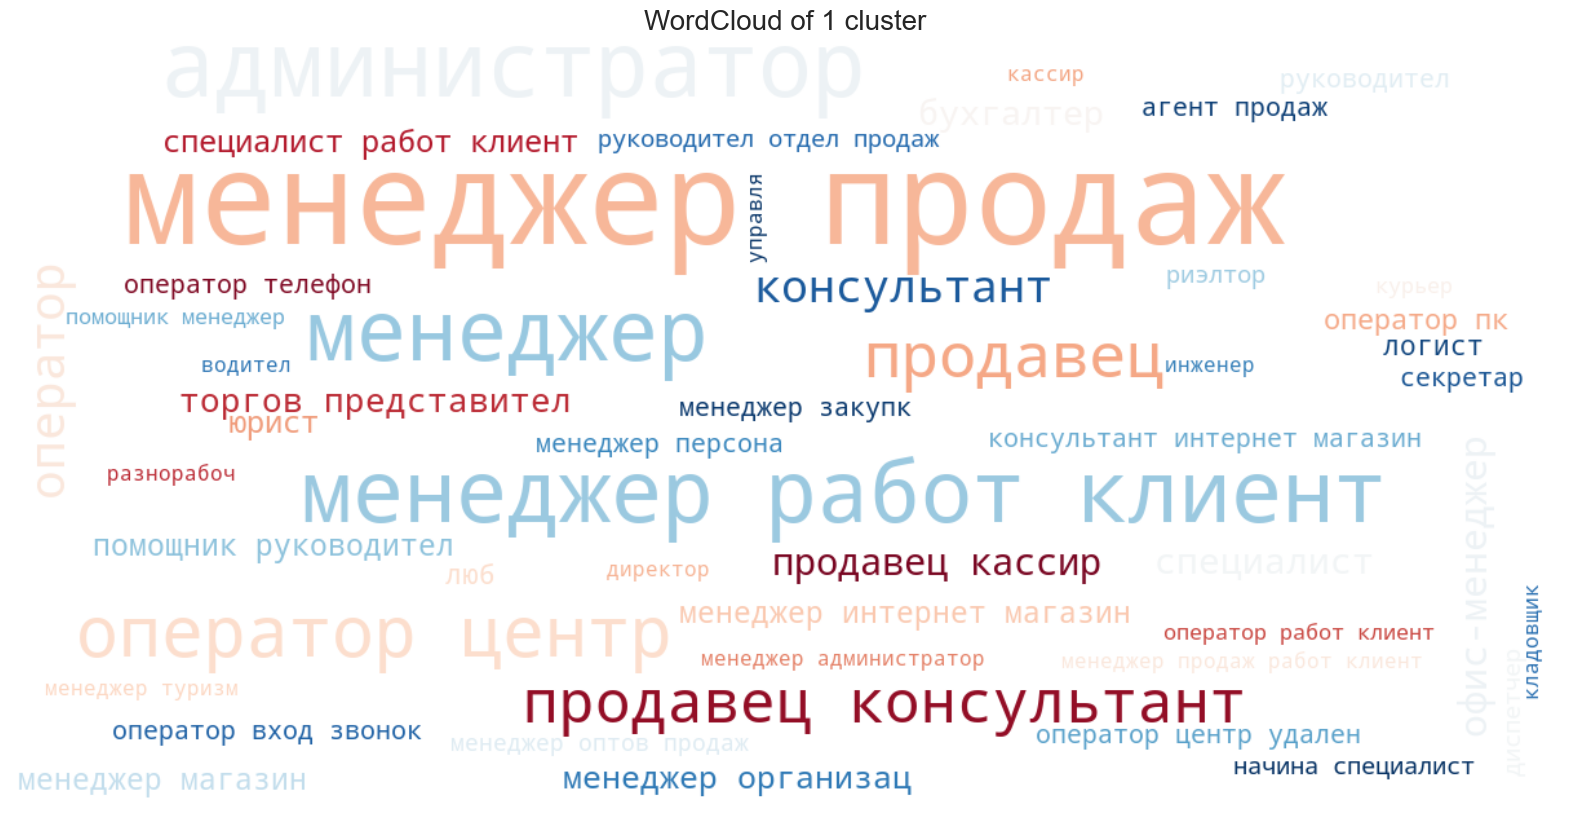

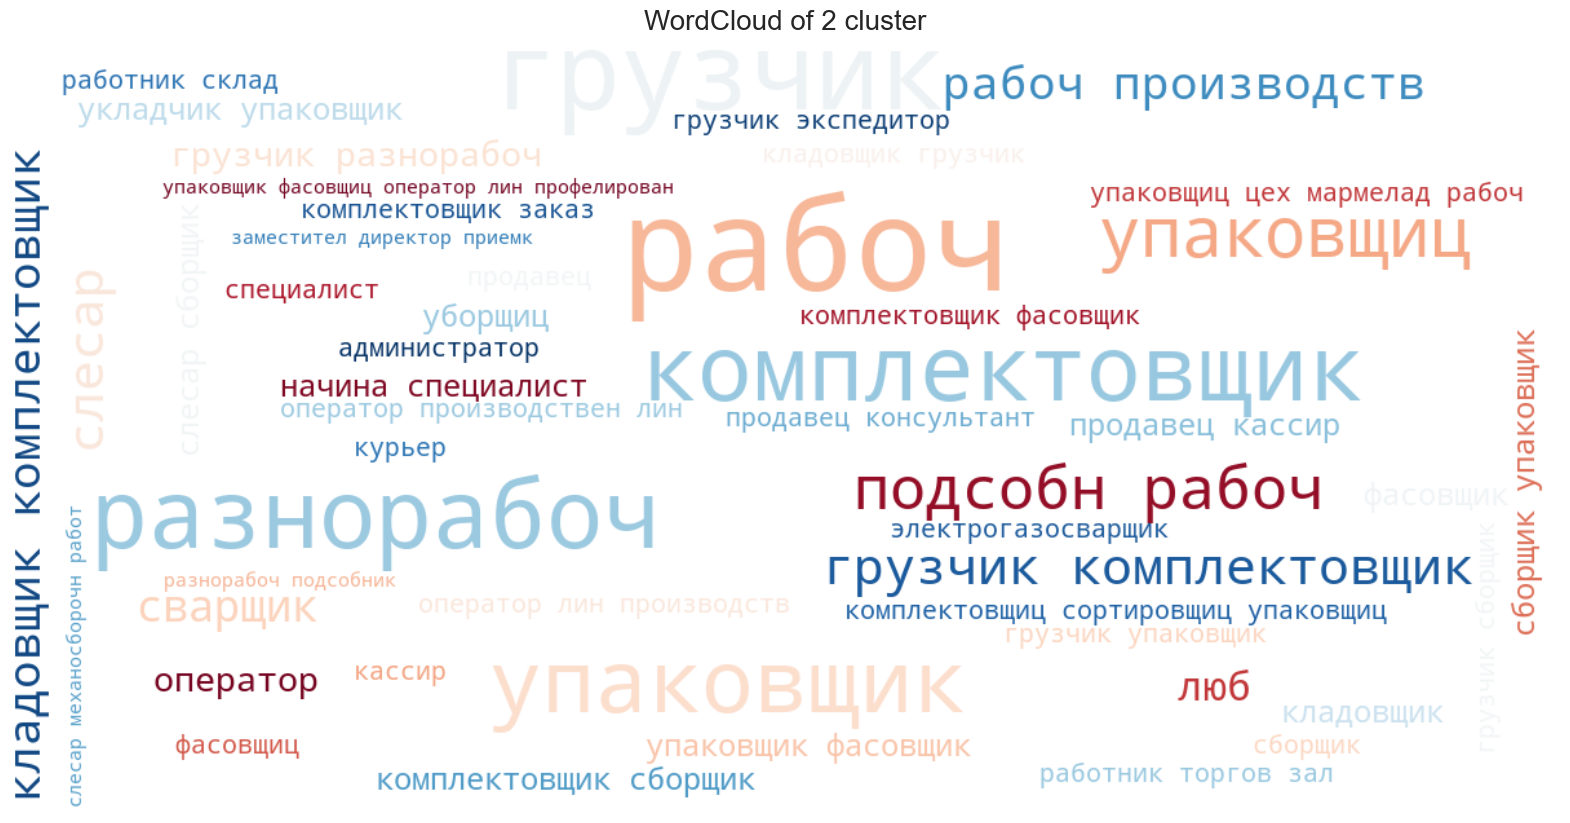

In [67]:
# По полученным кластерам выведем word cloud самых частых resume_position, которые чаще всего откликались на вакансиию
# Так косвенно можно сделать вывод о каких должностях идет речь в вакансия

# Рассмотрим  подробнее первые 3 кластера

for i in range(3):
    data_prof = df[df['TextCluster'] ==i]['resume_position'].values.tolist()

    freq_df = Freq_df(data_prof)
    data = dict(zip(freq_df['Term'].tolist(), freq_df['Frequency'].tolist()))
    data = freq_df.set_index('Term').to_dict()['Frequency']
    title = f'WordCloud of {i} cluster'
    word_cloud(data ,'white','RdBu', title)
    
# Кластер 0 - работа для курьеров (как пеших так и с личным автомобилем), водителей
# Кластер 1  - менеджеры по работе с клиентами, реже продавци и операторы call-центров
# Кластер 2  -  разнорабочие, подсобные рабочие, грузчики

# Предобработка признаков

Напишите трансформер, который будет делать следующее:

* Масштабирование через StandardScaler для вещественных колонок
* Кодирование через OneHotEncoder для категориальных, содержащих бинарные категории
* Кодирование через HashingEncoder для всех id категориальных фичей.
* Удалять колонки, которые мы еще хотим удалить (для этого напишем кастомный класс)


P.S.: Для деревьев процедура StandardScaling не обязательна (решающие деревья нечувствительны к масштабу). Тем не менее, это может сделать обучение модели менее тяжелым (хранить большие числа сложно для задач с большим количеством данных).

In [72]:
class CustomDrop(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_col=None, drop_idx = None):
        self.drop_col = drop_col
        self.drop_idx = drop_idx
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_= X.copy()
        X_= X_.drop(self.drop_col, axis=1)

        return X_

In [162]:
# признаки по колонкам

X = df.drop(['target_task_1','target_task_2'], axis = 1)
y_1= df['target_task_1']
y_2 = df['target_task_2']


# Запишем индексыв отдельную переменную

numeric_cols =  [
    'resume_salary_from', 
    'vacancy_salary_from', 
    'percentage_of_resume_completion',
    'resume_age'
]
numeric_cols_idx = [list(X.columns).index(col) for col in numeric_cols]


# Колонки для удаления
drop_col = [
    'resume_id',
    'vacancy_id',
    'resume_offer_experience_year_count',
    'vacancy_offer_experience_year_count',
    'vacancy_operating_schedule_comment', 
    'vacancy_offer_experience_year_id', 
    'vacancy_salary_to', 
    'vacancy_description',
    'resume_is_foreign_language'
]
drop_col_idx  = [list(X.columns).index(col) for col in drop_col]

# Категориальные признаки для OneHotEncoding и их индексы
ohe_col = bool_features
ohe_col_idx = [list(X.columns).index(col) for col in ohe_col]

# Категориальные признаки для HashEncoding и их индексы
hash_col = [
    'resume_city_id', 
    'vacancy_offer_education_id', 
    'resume_offer_education_id',
    'vacancy_city_id',
    'vacancy_company_id',
    'TextCluster'
]


In [166]:
col_transform = make_column_transformer((TfidfVectorizer(max_features=50),'resume_position'),
                             (StandardScaler(), numeric_cols_idx),
                             (OneHotEncoder(drop = 'first'), ohe_col_idx ),
                              (CustomDrop(drop_col), drop_col),
                              (HashingEncoder(cols=hash_col, n_components=1000), hash_col))

# Задание 1

Целевая переменная – откликнется (1) или не откликнется (0) соискатель с данным резюме на данную вакансию.

Пусть мы пусть мы хотим помочь рекрутарам и уменьшить количество приглашений на собеседование и более достоверно определять интерес соискателя к вакансии, т.е.  не беспокоить рекруторов и соискателей из-за ложноположительных результатов.
Аргементируем это ограниченным  количеством ресурсов рекруторов и желанием работодателя снизить временные издержи на поиск нового сотрудника. 

Поэтому оценивать модель будем по Precision. Precision можно интерпретировать как долю объектов, названных классификатором положительными и при этом действительно являющимися положительными.

__Выбор модели__:
Допустим у нас нет запроса от бизнеса на интерпретируемость результатов. Поэтому мы смело можем пользоваться нелинейными моделями.

Из-за ограниченных мощность я не буду прибегать к ансамблевым моделям. В случаи плохих результатов предложу ряд действий, которые по моему мнению могут помочь исправить ситуацию в лучшею сторону.

Поэтому в качестве основного алгоритма выберу DecisionTreeClassifier.


In [185]:
# Разделим набор данных на подмножества обучения и проверки:

X_train, X_test, y1_train, y1_test = train_test_split(X, y_1, test_size=0.2, shuffle= True,random_state=seed)

cv = KFold(n_splits=3, shuffle=True)

pipe_dt = Pipeline([('column_transformer',
                     col_transform),
                     
                    ('decision_tree', DecisionTreeClassifier(random_state=seed))])

# Выберем набор гиперпараметров 
param_grid = {
    'decision_tree__criterion': ["gini", "entropy"],
    'decision_tree__max_depth': [40, 45, 50],
    'decision_tree__min_samples_split': [50000, 400000],
    'decision_tree__max_leaf_nodes': [100]
}

# Передадим в GridSearchCV

search = GridSearchCV(pipe_dt, 
                      param_grid, 
                      cv=cv,
                     scoring = 'precision')

search.fit(X_train, y1_train)


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('tfidfvectorizer',
                                                                         TfidfVectorizer(max_features=50),
                                                                         'resume_position'),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         [3, 15,
                                                                          10,
                                                                          25]),
                                                                        ('onehotencoder',
                                                                   

In [208]:

print(f"Качество лучшей модели на трейне: {search.score(X_train, y1_train)}")
print(f"Качество лучшей модели на финальном тесте: {search.score(X_test, y1_test)}")

Качество лучшей модели на трейне: 0.5155901356254486
Качество лучшей модели на финальном тесте: 0.5136445625400027


In [187]:
print(f"Best parameter (CV score={search.best_score_:.5f}):")
print(search.best_params_)

Best parameter (CV score=0.51463):
{'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 40, 'decision_tree__max_leaf_nodes': 100, 'decision_tree__min_samples_split': 50000}


In [188]:
# precision оставляет желать лучшего. Есть куда работать
# Но отметим, что модель не переучилась (обобщающая способноть в порядке).
# Но Recall выше.
# Хотелось бы наращивать Precision в ущерб Recall, чтобы отвечать требования поставленной задачи.

# Идеи как это можно поправить:
# 1. Усложнять модель, чтобы она находила более сложные закономерности. Применять ансамбли 
# 2. Лучше порабоать над отбором признаков
# 3. Стратифицировать выборку и для каждой страты строить свою модель (при условии достаточности данных)

print(f'Accuracy равно: {accuracy_score(y1_test, search.predict(X_test)):.3f}' )
print(f'Precision равно: {precision_score(y1_test, search.predict(X_test)):.3f}' )
print(f'Recall равно: {recall_score(y1_test, search.predict(X_test)):.3f}' )
print(f'F-мера равно: {f1_score(y1_test, search.predict(X_test)):.3f}' )

Accuracy равно: 0.522
Precision равно: 0.514
Recall равно: 0.915
F-мера равно: 0.658


# Задание 2

Этап 2. Основываясь на данных первой части конкурса, необходимо разработать сервис предсказания действия работодателя. 
Пригласит ли работодатель откликнувшегося соискателя на собеседование.

In [175]:
# Разделим набор данных на подмножества обучения и проверки.
# Стратификация - это метод равномерного распределения выборок на основе классов выборок, 
# чтобы обучающий набор и проверочный набор имели одинаковое соотношение классов.

X_train, X_test, y2_train, y2_test = train_test_split(X, y_2, test_size=0.2, random_state=seed)

scv = StratifiedKFold(n_splits=3)

pipe_dt_2 = Pipeline([('column_transformer',
                     col_transform),
                     
                    ('decision_tree', DecisionTreeClassifier(random_state=seed))])

# Выберем набор гиперпараметров 
param_grid = {
    "decision_tree__max_depth": [30, 35],
    "decision_tree__min_samples_split": [50000],
    "decision_tree__max_leaf_nodes": [100, 1000]
}

# Передадим в GridSearchCV

search_3 = GridSearchCV(pipe_dt_2, param_grid, cv=scv, scoring = 'precision')

search_3.fit(X_train, y2_train)



GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('tfidfvectorizer',
                                                                         TfidfVectorizer(max_features=50),
                                                                         'resume_position'),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         [3, 15,
                                                                          10,
                                                                          25]),
                                                                        ('onehotencoder',
                                                        

In [176]:

print(f"Качество лучшей модели на трейне: {search_3.score(X_train, y2_train)}")
print(f"Качество лучшей модели на финальном тесте: {search_3.score(X_test, y2_test)}")
print(f"Best parameter (CV score={search_3.best_score_:.5f}):")
print(search_3.best_params_)

Качество лучшей модели на трейне: 0.8586440677966102
Качество лучшей модели на финальном тесте: 0.8580425319346321
Best parameter (CV score=0.85803):
{'decision_tree__max_depth': 35, 'decision_tree__max_leaf_nodes': 100, 'decision_tree__min_samples_split': 50000}


In [177]:
# И вроде всё хорошо - на трейне и на тесте качество модели одинаковые (обобщающая способноть в порядке).
# Достаточно хороший Precision на тесте.
# Но Recall выше. Скорее всего алгоритм помечает некоторые объекты класса 0  как класс 1.

# Идеи как это можно поправить:
# 1. Усложнять модель, чтобы она находила более сложные закономерности. Применять ансамбли 
# 2. Скорректировать при помощи весов дисбаланс классов

print(f'Accuracy равно: {accuracy_score(y2_test, search_3.predict(X_test)):.3f}' )
print(f'Precision равно: {precision_score(y2_test, search_3.predict(X_test)):.3f}' )
print(f'Recall равно: {recall_score(y2_test, search_3.predict(X_test)):.3f}' )
print(f'F-мера равно: {f1_score(y2_test, search_3.predict(X_test)):.3f}' )

Accuracy равно: 0.853
Precision равно: 0.858
Recall равно: 0.990
F-мера равно: 0.919


In [184]:
print(classification_report(y2_test, search_3.predict(X_test)))

              precision    recall  f1-score   support

           0       0.68      0.11      0.19      8975
           1       0.86      0.99      0.92     48577

    accuracy                           0.85     57552
   macro avg       0.77      0.55      0.56     57552
weighted avg       0.83      0.85      0.81     57552

